In [15]:
import torch

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

In [9]:
DEVICE = 'cuda:0'
BATCH_SIZE = 1
EPOCHS = 10

<br>

## Define Teacher and Student Network

In [10]:
pretrained_vgg = models.vgg19(pretrained=True)
teacher = pretrained_vgg.features[:36]
teacher = teacher.to(DEVICE)

In [11]:
vgg = models.vgg19(pretrained=False)
student = vgg.features[:36]
student = student.to(DEVICE)

<br>

## Prepare Dataset

In [12]:
transform = transforms.Compose([transforms.Grayscale(3), # Match the mnist channel dim with vgg19 input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

mnist = datasets.MNIST(root='/dgx/inoue/data', 
                       train=True, 
                       download=True,
                       transform=transform)

train_loader = DataLoader(dataset=mnist,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

<br>

## Train Student Network

In [13]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

In [16]:
teacher.eval()

for epoch in tqdm(range(EPOCHS)):
    for i, (img, digit) in enumerate(train_loader):
         
        if digit == 1:
            img = img.to(DEVICE)
            with torch.no_grad():
                surrogate_label = teacher(img)
            optimizer.zero_grad()
            pred = student(img)
            loss = criterion(pred, surrogate_label)
            loss.backward()
            optimizer.step()

100%|██████████| 10/10 [22:25<00:00, 134.53s/it]


<br>

## Measure Anomaly Score

In [17]:
teacher.eval()
student.eval()

losses = []
digits = []
for img, digit in tqdm(train_loader):
    with torch.no_grad():
        img = img.to(DEVICE)
        surrogate_label = teacher(img)
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        
        losses.append(loss.item())
        digits.append(digit)

100%|██████████| 60000/60000 [05:42<00:00, 175.11it/s]


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


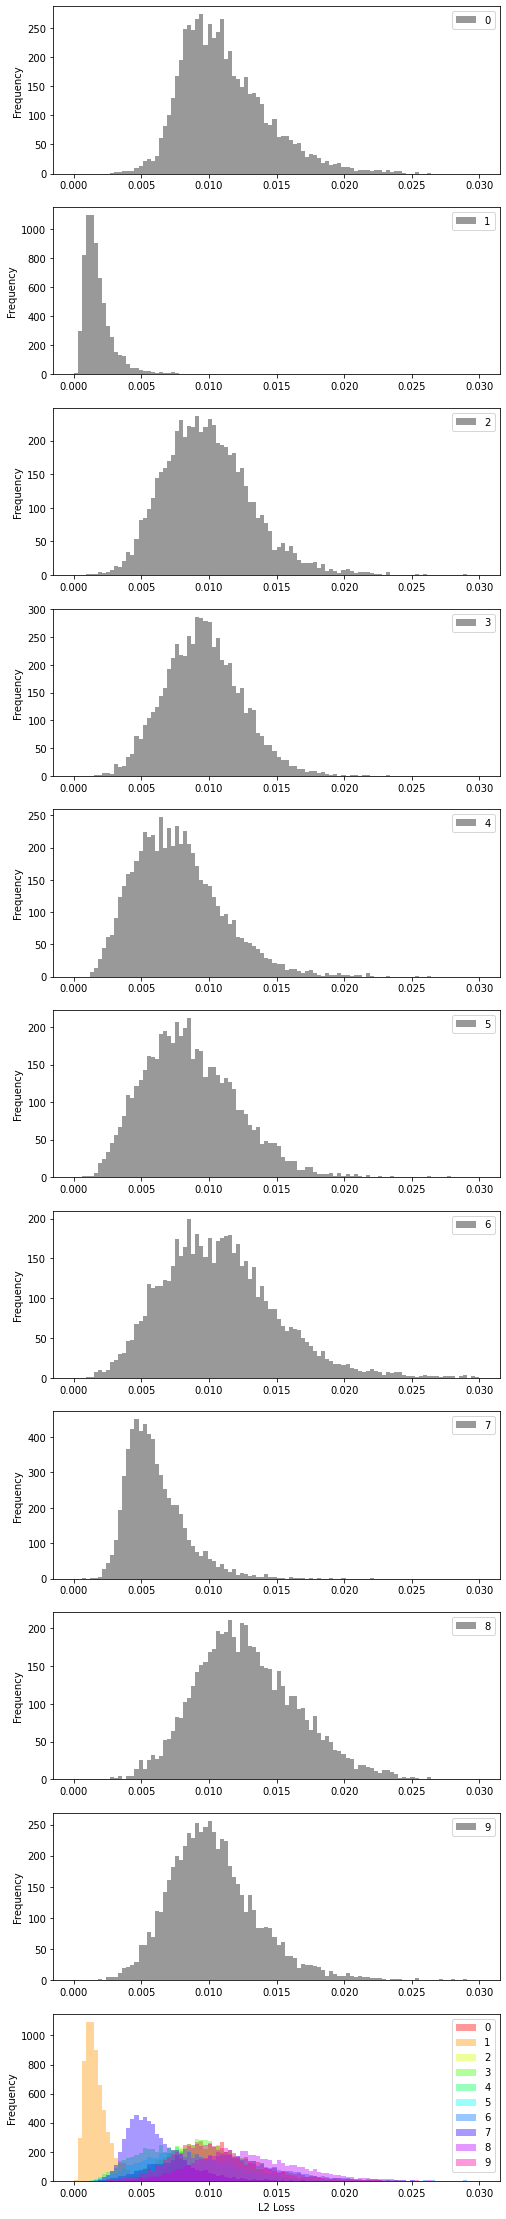

In [68]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

losses = np.array(losses)
digits = np.array(digits)

plt.figure(figsize=(8, 40))
for i in range(10):
    plt.subplot(11, 1, i+1)
    plt.hist(losses[digits==i], range=(0, 0.03), label=str(i), bins=100, color='k', alpha=0.4)
    plt.legend()
    plt.ylabel('Frequency')

    
    plt.subplot(11, 1, 11)
    color = cm.hsv(i/10)
    plt.hist(losses[digits==i], range=(0, 0.03), label=str(i), bins=100, color=color, alpha=0.4)

plt.legend()
plt.xlabel('L2 Loss')
plt.ylabel('Frequency')
plt.show()